In [2]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bvh_converter import bvh_mod
from scipy.signal import savgol_filter

from matplotlib.lines import Line2D
from scipy.interpolate import interp1d

## v1

In [4]:
def plot_foot_trajectories_by_subdiv(
    file_name: str,
    mode: str,
    subdiv_set: list,  # e.g. [2,5,8,11] or [3,6,9,12]
    base_path_cycles: str = "data/virtual_cycles",
    base_path_logs: str = "data/logs_v1_may",
    frame_rate: float = 240,
    time_segments: list = None,  # List of (start, end) tuples
    n_beats_per_cycle: int = 4,
    n_subdiv_per_beat: int = 12,
    nn: int = 8,
    figsize: tuple = (12, 6),
    dpi: int = 200,
    use_cycles: bool = True,
    show_gray_plots: bool = True
):
    """
    Plot left- and right-foot Y-position trajectories ±window around specified subdivisions,
    marking foot-onset times for cycles that have an onset in the window.
    Optionally plots trajectories for cycles without onsets in gray.

    Parameters
    ----------
    [previous parameters remain the same]
    time_segments : list of tuples
        List of (start, end) time segments to plot. If None, uses default window.
    """
    if len(subdiv_set) != n_beats_per_cycle:
        raise ValueError(f"subdiv_set must have length {n_beats_per_cycle}")

    # Use default window if no segments provided
    if time_segments is None:
        time_segments = [(170.0, 185.0)]

    # build file paths
    cycles_csv = os.path.join(base_path_cycles, f"{file_name}_C.csv")
    logs_onset_dir = os.path.join(base_path_logs, f"{file_name}_T", "onset_info")
    left_onsets_csv  = os.path.join(logs_onset_dir, f"{file_name}_T_left_foot_onsets.csv")
    right_onsets_csv = os.path.join(logs_onset_dir, f"{file_name}_T_right_foot_onsets.csv")
    left_zpos_csv    = os.path.join(logs_onset_dir, f"{file_name}_T_left_foot_zpos.csv")
    right_zpos_csv   = os.path.join(logs_onset_dir, f"{file_name}_T_right_foot_zpos.csv")

    # load data
    Lz = pd.read_csv(left_zpos_csv)["zpos"].values
    Rz = pd.read_csv(right_zpos_csv)["zpos"].values
    n_frames = len(Lz)
    times = np.arange(n_frames) / frame_rate

    # interpolation functions
    L_interp = interp1d(times, Lz, bounds_error=False, fill_value="extrapolate")
    R_interp = interp1d(times, Rz, bounds_error=False, fill_value="extrapolate")

    # Get overall time range for color mapping
    total_start = min(seg[0] for seg in time_segments)
    total_end = max(seg[1] for seg in time_segments)
    t_range = total_end - total_start

    # Calculate average cycle duration from all segments
    all_onsets = []
    for seg_start, seg_end in time_segments:
        cyc_df = pd.read_csv(cycles_csv)
        cyc_df = cyc_df[(cyc_df["Virtual Onset"] >= seg_start) & (cyc_df["Virtual Onset"] <= seg_end)]
        if not cyc_df.empty:
            all_onsets.extend(cyc_df["Virtual Onset"].values[:-1])
    
    if not all_onsets:
        raise ValueError("No cycles found in any of the time segments")
    
    # Calculate average cycle duration
    durations = np.diff(sorted(all_onsets))
    avg_cycle = durations.mean()

    # Calculate beat and subdivision lengths
    beat_len = avg_cycle / n_beats_per_cycle
    subdiv_len = beat_len / n_subdiv_per_beat
    half_win = subdiv_len * nn

    # Create figure with subplots for each beat
    fig, axes = plt.subplots(2, 2, figsize=figsize, dpi=dpi)
    axes = axes.flatten()
    cmap = plt.get_cmap('cool')

    # For each beat position (1,2,3,4)
    for beat_idx, ax in enumerate(axes):
        # Calculate time offset for this subdivision
        subdiv_offset = (subdiv_set[beat_idx] - 1) * subdiv_len  # -1 because subdivisions are 1-based
        beat_offset = beat_idx * beat_len
        total_offset = beat_offset + subdiv_offset

        # Process each time segment
        for seg_start, seg_end in time_segments:
            # trim to window
            win_mask = (times >= seg_start) & (times <= seg_end)
            t_win = times[win_mask]
            L_win = Lz[win_mask]
            R_win = Rz[win_mask]

            # cycles (downbeats)
            cyc_df = pd.read_csv(cycles_csv)
            cyc_df = cyc_df[(cyc_df["Virtual Onset"] >= seg_start) & (cyc_df["Virtual Onset"] <= seg_end)]
            onsets = cyc_df["Virtual Onset"].values[:-1]

            # foot onsets
            left_df  = pd.read_csv(left_onsets_csv)
            right_df = pd.read_csv(right_onsets_csv)
            left_times  = left_df[ (left_df["time_sec"]>=seg_start)&(left_df["time_sec"]<=seg_end) ]["time_sec"].values
            right_times = right_df[(right_df["time_sec"]>=seg_start)&(right_df["time_sec"]<=seg_end)]["time_sec"].values

            # Plot gray trajectories if enabled
            if show_gray_plots:
                for c in onsets:
                    subdiv_time = c + total_offset
                    m = (t_win>=subdiv_time-half_win)&(t_win<=subdiv_time+half_win)
                    tr = t_win[m] - subdiv_time
                    if use_cycles:
                        tr = tr / avg_cycle
                    ax.plot(tr, L_win[m], '-', color='gray', alpha=0.1)
                    ax.plot(tr, R_win[m], '--', color='gray', alpha=0.1)

            # Collect cycles that have foot onsets near this subdivision
            cyc_L, L_near = [], {}
            cyc_R, R_near = [], {}
            
            for c in onsets:
                subdiv_time = c + total_offset
                # Left foot
                hits = left_times[(left_times>=subdiv_time-half_win)&(left_times<=subdiv_time+half_win)]
                if len(hits):
                    cyc_L.append(c)
                    L_near[c] = hits
                # Right foot
                hits = right_times[(right_times>=subdiv_time-half_win)&(right_times<=subdiv_time+half_win)]
                if len(hits):
                    cyc_R.append(c)
                    R_near[c] = hits

            # Plot left foot trajectories with onsets
            for i, c in enumerate(cyc_L):
                col = cmap((c-total_start)/t_range)
                subdiv_time = c + total_offset
                m = (t_win>=subdiv_time-half_win)&(t_win<=subdiv_time+half_win)
                tr = t_win[m] - subdiv_time
                if use_cycles:
                    tr = tr / avg_cycle
                ax.plot(tr, L_win[m], '-', color=col, alpha=0.3,
                        label="Left Foot" if i==0 else "")
                for lt in L_near[c]:
                    rel = lt - subdiv_time
                    if use_cycles:
                        rel = rel / avg_cycle
                    ax.axvline(rel, color=col, linestyle='-', alpha=0.5)
                    ax.plot(rel, L_interp(lt), 'o', ms=8, markeredgecolor='k', alpha=0.8)

            # Plot right foot trajectories with onsets
            for i, c in enumerate(cyc_R):
                col = cmap((c-total_start)/t_range)
                subdiv_time = c + total_offset
                m = (t_win>=subdiv_time-half_win)&(t_win<=subdiv_time+half_win)
                tr = t_win[m] - subdiv_time
                if use_cycles:
                    tr = tr / avg_cycle
                ax.plot(tr, R_win[m], '--', color=col, alpha=0.3,
                        label="Right Foot" if i==0 else "")
                for rt in R_near[c]:
                    rel = rt - subdiv_time
                    if use_cycles:
                        rel = rel / avg_cycle
                    ax.axvline(rel, color=col, linestyle='--', alpha=0.5)
                    ax.plot(rel, R_interp(rt), 'x', ms=8, markeredgecolor='k', alpha=0.8)

        # Decorations for each subplot
        ax.axvline(0, color='k', linewidth=1.5, label="Subdivision (t=0)")
        for j in range(-nn, nn+1):
            if j!=0:
                pos = j*subdiv_len
                if use_cycles:
                    pos = pos / avg_cycle
                ax.axvline(pos, color='gray', linestyle=':', alpha=0.5)

        xlabel = "Cycles relative to subdivision" if use_cycles else "Time relative to subdivision (s)"
        ax.set_xlabel(xlabel)
        ax.set_ylabel("Foot Y Position")
        ax.set_title(f"Beat {beat_idx + 1}, Subdivision {subdiv_set[beat_idx]}")
        ax.grid(True, alpha=0.3)

        # Add legend only to first subplot
        if beat_idx == 0:
            custom = [
                Line2D([0],[0],color='blue',linestyle='-', lw=2),
                Line2D([0],[0],marker='o', color='w', markerfacecolor='blue', ms=8, markeredgecolor='k'),
                Line2D([0],[0],color='blue',linestyle='--', lw=2),
                Line2D([0],[0],marker='x', color='w', markeredgecolor='blue', ms=8),
                Line2D([0],[0],color='k', lw=2)
            ]
            labels = ["Left Trajectory","Left Onset","Right Trajectory",
                     "Right Onset","Subdivision (t=0)"]
            ax.legend(custom, labels, loc='upper left', framealpha=0.3)

    # Add colorbar to the figure
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(total_start, total_end))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axes.ravel().tolist())
    cbar.set_label('Time in recording (s)')

    # Create segment labels for title
    segment_labels = [f"{start:.1f}-{end:.1f}s" for start, end in time_segments]
    segment_str = " | ".join(segment_labels)

    plt.suptitle(
        f"Foot Trajectories ±{2*nn/n_subdiv_per_beat/ n_beats_per_cycle:.1f} beats around subdivisions {subdiv_set}\n"
        f"{file_name} | segments: {segment_str} | {mode}",
        fontsize=10
    )
    
    plt.subplots_adjust(top=0.85)
    fig.set_constrained_layout(True)

    return fig, axes

In [ ]:
mode_csv_list = os.listdir("data/subset_dance_annotation")

for mode_csv in mode_csv_list:
    file_name = mode_csv.split("_Dancers")[0]
    mode_df = pd.read_csv("data/subset_dance_annotation/" + mode_csv)

    mode_group = mode_df[mode_df["mocap"] == "gr"].reset_index(drop=True)
    mode_individual = mode_df[mode_df["mocap"] == "in"].reset_index(drop=True)
    mode_audience = mode_df[mode_df["mocap"] == "au"].reset_index(drop=True)

    # helper to extract all (start, end) tuples for a mode
    def get_segments(df, name):
        if df.empty:
            print(f"⚠️  No rows for mode '{name}', skipping.")
            return None
        return [(row["Start (in sec)"], row["End (in sec)"]) for _, row in df.iterrows()]

    # build a dict of segments
    segments = {
        "group":      get_segments(mode_group,      "gr"),
        "individual": get_segments(mode_individual, "in"),
        "audience":   get_segments(mode_audience,   "au")
    }

    # filter out the empty ones
    tsegment = {mode: seg for mode, seg in segments.items() if seg is not None}

    save_dir = f"output_static_plot/foot_trajectories/{file_name}"
    os.makedirs(save_dir, exist_ok=True)
    for mode, segments in tsegment.items():
        fig, ax = plot_foot_trajectories_by_subdiv(
            file_name=file_name,
            mode=mode,
            base_path_cycles="data/virtual_cycles",
            base_path_logs="data/logs_v1_may",
            time_segments=segments,  # Pass all segments for this mode
            n_beats_per_cycle=4, 
            n_subdiv_per_beat=12, 
            nn=8,
            use_cycles=True,
            show_gray_plots=True,
            subdiv_set=[2,5,8,11]
        )
        # Create a filename that includes all segments
        # segment_str = "_".join([f"{start:.1f}_{end:.1f}" for start, end in segments])
        fig.savefig(os.path.join(save_dir, f"{file_name}_{mode}.png"))
        plt.close(fig)

## v2: plot_foot_trajectories_by_subdiv multi mode

In [2]:
def plot_foot_trajectories_by_subdiv(
    file_name: str,
    mode: str,
    subdiv_set: list,  # e.g. [2,5,8,11] or [3,6,9,12]
    base_path_cycles: str = "data/virtual_cycles",
    base_path_logs: str = "data/logs_v1_may",
    frame_rate: float = 240,
    time_segments: list = None,  # List of (start, end) tuples
    n_beats_per_cycle: int = 4,
    n_subdiv_per_beat: int = 12,
    nn: int = 8,
    figsize: tuple = (12, 6),
    dpi: int = 200,
    use_cycles: bool = True,
    show_gray_plots: bool = True,
    show_trajectories: bool = True,  # New parameter to control trajectory lines
    show_vlines: bool = True        # New parameter to control vertical lines
):
    """
    Plot left- and right-foot Y-position trajectories ±window around specified subdivisions,
    marking foot-onset times for cycles that have an onset in the window.
    Optionally plots trajectories for cycles without onsets in gray.

    Parameters
    ----------
    [previous parameters remain the same]
    show_trajectories : bool
        Whether to show the continuous trajectory lines
    show_vlines : bool
        Whether to show vertical lines at onset times
    """
    if len(subdiv_set) != n_beats_per_cycle:
        raise ValueError(f"subdiv_set must have length {n_beats_per_cycle}")

    # Use default window if no segments provided
    if time_segments is None:
        time_segments = [(170.0, 185.0)]

    # build file paths
    cycles_csv = os.path.join(base_path_cycles, f"{file_name}_C.csv")
    logs_onset_dir = os.path.join(base_path_logs, f"{file_name}_T", "onset_info")
    left_onsets_csv  = os.path.join(logs_onset_dir, f"{file_name}_T_left_foot_onsets.csv")
    right_onsets_csv = os.path.join(logs_onset_dir, f"{file_name}_T_right_foot_onsets.csv")
    left_zpos_csv    = os.path.join(logs_onset_dir, f"{file_name}_T_left_foot_zpos.csv")
    right_zpos_csv   = os.path.join(logs_onset_dir, f"{file_name}_T_right_foot_zpos.csv")

    # load data
    Lz = pd.read_csv(left_zpos_csv)["zpos"].values
    Rz = pd.read_csv(right_zpos_csv)["zpos"].values
    n_frames = len(Lz)
    times = np.arange(n_frames) / frame_rate

    # interpolation functions
    L_interp = interp1d(times, Lz, bounds_error=False, fill_value="extrapolate")
    R_interp = interp1d(times, Rz, bounds_error=False, fill_value="extrapolate")

    # Get overall time range for color mapping
    total_start = min(seg[0] for seg in time_segments)
    total_end = max(seg[1] for seg in time_segments)
    t_range = total_end - total_start

    # Calculate average cycle duration from all segments
    all_onsets = []
    for seg_start, seg_end in time_segments:
        cyc_df = pd.read_csv(cycles_csv)
        cyc_df = cyc_df[(cyc_df["Virtual Onset"] >= seg_start) & (cyc_df["Virtual Onset"] <= seg_end)]
        if not cyc_df.empty:
            all_onsets.extend(cyc_df["Virtual Onset"].values[:-1])
    
    if not all_onsets:
        raise ValueError("No cycles found in any of the time segments")
    
    # Calculate average cycle duration
    durations = np.diff(sorted(all_onsets))
    avg_cycle = durations.mean()

    # Calculate beat and subdivision lengths
    beat_len = avg_cycle / n_beats_per_cycle
    subdiv_len = beat_len / n_subdiv_per_beat
    half_win = subdiv_len * nn

    # Create figure with subplots for each beat
    fig, axes = plt.subplots(2, 2, figsize=figsize, dpi=dpi)
    axes = axes.flatten()
    cmap = plt.get_cmap('cool')

    # For each beat position (1,2,3,4)
    for beat_idx, ax in enumerate(axes):
        # Calculate time offset for this subdivision
        subdiv_offset = (subdiv_set[beat_idx] - 1) * subdiv_len  # -1 because subdivisions are 1-based
        # beat_offset = beat_idx * beat_len
        # total_offset = beat_offset + subdiv_offset
        total_offset = subdiv_offset

        # Process each time segment
        for seg_start, seg_end in time_segments:
            # trim to window
            win_mask = (times >= seg_start) & (times <= seg_end)
            t_win = times[win_mask]
            L_win = Lz[win_mask]
            R_win = Rz[win_mask]

            # cycles (downbeats)
            cyc_df = pd.read_csv(cycles_csv)
            cyc_df = cyc_df[(cyc_df["Virtual Onset"] >= seg_start) & (cyc_df["Virtual Onset"] <= seg_end)]
            onsets = cyc_df["Virtual Onset"].values[:-1]

            # foot onsets
            left_df  = pd.read_csv(left_onsets_csv)
            right_df = pd.read_csv(right_onsets_csv)
            left_times  = left_df[ (left_df["time_sec"]>=seg_start)&(left_df["time_sec"]<=seg_end) ]["time_sec"].values
            right_times = right_df[(right_df["time_sec"]>=seg_start)&(right_df["time_sec"]<=seg_end)]["time_sec"].values

            # Plot gray trajectories if enabled
            if show_gray_plots and show_trajectories:
                for c in onsets:
                    subdiv_time = c + total_offset
                    m = (t_win>=subdiv_time-half_win)&(t_win<=subdiv_time+half_win)
                    tr = t_win[m] - subdiv_time
                    if use_cycles:
                        tr = tr / avg_cycle
                    ax.plot(tr, L_win[m], '-', color='gray', alpha=0.1)
                    ax.plot(tr, R_win[m], '--', color='gray', alpha=0.1)

            # Collect cycles that have foot onsets near this subdivision
            cyc_L, L_near = [], {}
            cyc_R, R_near = [], {}
            
            for c in onsets:
                subdiv_time = c + total_offset
                # Left foot
                hits = left_times[(left_times>=subdiv_time-half_win)&(left_times<=subdiv_time+half_win)]
                if len(hits):
                    cyc_L.append(c)
                    L_near[c] = hits
                # Right foot
                hits = right_times[(right_times>=subdiv_time-half_win)&(right_times<=subdiv_time+half_win)]
                if len(hits):
                    cyc_R.append(c)
                    R_near[c] = hits

            # Plot left foot trajectories with onsets
            for i, c in enumerate(cyc_L):
                col = cmap((c-total_start)/t_range)
                subdiv_time = c + total_offset
                m = (t_win>=subdiv_time-half_win)&(t_win<=subdiv_time+half_win)
                tr = t_win[m] - subdiv_time
                if use_cycles:
                    tr = tr / avg_cycle
                if show_trajectories:
                    ax.plot(tr, L_win[m], '-', color=col, alpha=0.3,
                            label="Left Foot" if i==0 else "")
                for lt in L_near[c]:
                    rel = lt - subdiv_time  # or beat_time for by_beat version
                    if use_cycles:
                        rel = rel / avg_cycle
                    if show_vlines:
                        ax.axvline(rel, color=col, linestyle='-', alpha=0.5)
                    # Change this line to use a fixed color for left foot markers
                    ax.plot(rel, L_interp(lt), 'o', ms=8, markeredgecolor='k', 
                            markerfacecolor='blue', alpha=0.8)  # Fixed blue color for left foot

            # Plot right foot trajectories with onsets
            for i, c in enumerate(cyc_R):
                col = cmap((c-total_start)/t_range)
                subdiv_time = c + total_offset
                m = (t_win>=subdiv_time-half_win)&(t_win<=subdiv_time+half_win)
                tr = t_win[m] - subdiv_time
                if use_cycles:
                    tr = tr / avg_cycle
                if show_trajectories:
                    ax.plot(tr, R_win[m], '--', color=col, alpha=0.3,
                            label="Right Foot" if i==0 else "")
                for rt in R_near[c]:
                    rel = rt - subdiv_time  # or beat_time for by_beat version
                    if use_cycles:
                        rel = rel / avg_cycle
                    if show_vlines:
                        ax.axvline(rel, color=col, linestyle='--', alpha=0.5)
                    # Change this line to use a fixed color for right foot markers
                    ax.plot(rel, R_interp(rt), 'x', ms=8, markeredgecolor='red', 
                            color='red', alpha=0.8)  # Fixed red color for right foot

        # Decorations for each subplot
        ax.axvline(0, color='k', linewidth=1.5, label="Subdivision (t=0)")
        for j in range(-nn, nn+1):
            if j!=0:
                pos = j*subdiv_len
                if use_cycles:
                    pos = pos / avg_cycle
                ax.axvline(pos, color='gray', linestyle=':', alpha=0.5)

        xlabel = "Cycles relative to subdivision" if use_cycles else "Time relative to subdivision (s)"
        ax.set_xlabel(xlabel)
        ax.set_ylabel("Foot Y Position")
        ax.set_title(f"Beat {beat_idx + 1}, Subdivision {subdiv_set[beat_idx]}")
        ax.grid(True, alpha=0.3)

        # Add legend only to first subplot
        if beat_idx == 0:
            custom = [
                # Line2D([0],[0],color='blue',linestyle='-', lw=2),
                Line2D([0],[0],marker='o', color='w', markerfacecolor='blue', ms=8, markeredgecolor='k'),
                # Line2D([0],[0],color='red',linestyle='--', lw=2),
                Line2D([0],[0],marker='x', color='red', ms=8),
                Line2D([0],[0],color='k', lw=2)
            ]
            # labels = ["Left Trajectory","Left Onset","Right Trajectory",
            #         "Right Onset","Beat (t=0)"] 
            labels = ["Left Onset", "Right Onset","Beat (t=0)"] 
            
            ax.legend(custom, labels, loc='upper left', framealpha=0.3)

    # Add colorbar to the figure
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(total_start, total_end))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axes.ravel().tolist())
    cbar.set_label('Time in recording (s)')

    # Create segment labels for title
    segment_labels = [f"{start:.1f}-{end:.1f}s" for start, end in time_segments]
    segment_str = " | ".join(segment_labels)

    plt.suptitle(
        f"Foot Trajectories ±{2*nn/n_subdiv_per_beat/ n_beats_per_cycle:.1f} beats around subdivisions {subdiv_set}\n"
        f"{file_name} | segments: all | {mode}",
        fontsize=10
    )
    
    plt.subplots_adjust(top=0.85)
    fig.set_constrained_layout(True)

    return fig, axes

### may 23

In [2]:
def plot_foot_trajectories_by_subdiv(
    file_name: str,
    mode: str,
    subdiv_set: list,  # e.g. [2,5,8,11] or [3,6,9,12]
    base_path_cycles: str = "data/virtual_cycles",
    base_path_logs: str = "data/logs_v1_may",
    frame_rate: float = 240,
    time_segments: list = None,  # List of (start, end) tuples
    n_beats_per_cycle: int = 4,
    n_subdiv_per_beat: int = 12,
    nn: int = 8,
    figsize: tuple = (12, 6),
    dpi: int = 200,
    use_cycles: bool = True,
    show_gray_plots: bool = True,
    show_trajectories: bool = True,  # New parameter to control trajectory lines
    show_vlines: bool = True        # New parameter to control vertical lines
):
    """
    Plot left- and right-foot Y-position trajectories ±window around specified subdivisions,
    marking foot-onset times for cycles that have an onset in the window.
    Optionally plots trajectories for cycles without onsets in gray.

    Parameters
    ----------
    [previous parameters remain the same]
    show_trajectories : bool
        Whether to show the continuous trajectory lines
    show_vlines : bool
        Whether to show vertical lines at onset times
    """
    if len(subdiv_set) != n_beats_per_cycle:
        raise ValueError(f"subdiv_set must have length {n_beats_per_cycle}")

    # Use default window if no segments provided
    if time_segments is None:
        time_segments = [(170.0, 185.0)]

    # build file paths
    cycles_csv = os.path.join(base_path_cycles, f"{file_name}_C.csv")
    logs_onset_dir = os.path.join(base_path_logs, f"{file_name}_T", "onset_info")
    left_onsets_csv  = os.path.join(logs_onset_dir, f"{file_name}_T_left_foot_onsets.csv")
    right_onsets_csv = os.path.join(logs_onset_dir, f"{file_name}_T_right_foot_onsets.csv")
    left_zpos_csv    = os.path.join(logs_onset_dir, f"{file_name}_T_left_foot_zpos.csv")
    right_zpos_csv   = os.path.join(logs_onset_dir, f"{file_name}_T_right_foot_zpos.csv")

    # load data
    Lz = pd.read_csv(left_zpos_csv)["zpos"].values
    Rz = pd.read_csv(right_zpos_csv)["zpos"].values
    n_frames = len(Lz)
    times = np.arange(n_frames) / frame_rate

    # interpolation functions
    L_interp = interp1d(times, Lz, bounds_error=False, fill_value="extrapolate")
    R_interp = interp1d(times, Rz, bounds_error=False, fill_value="extrapolate")

    # Get overall time range for color mapping
    total_start = min(seg[0] for seg in time_segments)
    total_end = max(seg[1] for seg in time_segments)
    t_range = total_end - total_start

    # Calculate average cycle duration from all segments
    all_onsets = []
    for seg_start, seg_end in time_segments:
        cyc_df = pd.read_csv(cycles_csv)
        cyc_df = cyc_df[(cyc_df["Virtual Onset"] >= seg_start) & (cyc_df["Virtual Onset"] <= seg_end)]
        if not cyc_df.empty:
            all_onsets.extend(cyc_df["Virtual Onset"].values[:-1])
    
    if not all_onsets:
        raise ValueError("No cycles found in any of the time segments")
    
    # Calculate average cycle duration
    durations = np.diff(sorted(all_onsets))
    avg_cycle = durations.mean()

    # Calculate beat and subdivision lengths
    beat_len = avg_cycle / n_beats_per_cycle
    subdiv_len = beat_len / n_subdiv_per_beat
    half_win = subdiv_len * nn

    # Create figure with subplots for each beat
    fig, axes = plt.subplots(2, 2, figsize=figsize, dpi=dpi)
    axes = axes.flatten()
    cmap = plt.get_cmap('cool')

    # Define subdivision color mapping
    def get_subdiv_color(subdiv):
        if subdiv in [1, 4, 7, 10]:
            return 'black'
        elif subdiv in [2, 5, 8, 11]:
            return 'green'
        elif subdiv in [3, 6, 9, 12]:
            return 'red'
        return 'gray'  # fallback color

    # For each beat position (1,2,3,4)
    for beat_idx, ax in enumerate(axes):
        current_subdiv = subdiv_set[beat_idx]
        subdiv_color = get_subdiv_color(current_subdiv)
        
        # Calculate time offset for this subdivision
        subdiv_offset = (current_subdiv - 1) * subdiv_len
        total_offset = subdiv_offset

        # Process each time segment
        for seg_start, seg_end in time_segments:
            # trim to window
            win_mask = (times >= seg_start) & (times <= seg_end)
            t_win = times[win_mask]
            L_win = Lz[win_mask]
            R_win = Rz[win_mask]

            # cycles (downbeats)
            cyc_df = pd.read_csv(cycles_csv)
            cyc_df = cyc_df[(cyc_df["Virtual Onset"] >= seg_start) & (cyc_df["Virtual Onset"] <= seg_end)]
            onsets = cyc_df["Virtual Onset"].values[:-1]

            # foot onsets
            left_df  = pd.read_csv(left_onsets_csv)
            right_df = pd.read_csv(right_onsets_csv)
            left_times  = left_df[ (left_df["time_sec"]>=seg_start)&(left_df["time_sec"]<=seg_end) ]["time_sec"].values
            right_times = right_df[(right_df["time_sec"]>=seg_start)&(right_df["time_sec"]<=seg_end)]["time_sec"].values

            # Plot gray trajectories if enabled
            if show_gray_plots and show_trajectories:
                for c in onsets:
                    subdiv_time = c + total_offset
                    m = (t_win>=subdiv_time-half_win)&(t_win<=subdiv_time+half_win)
                    tr = t_win[m] - subdiv_time
                    if use_cycles:
                        tr = tr / beat_len
                    ax.plot(tr, L_win[m], '-', color='gray', alpha=0.3)
                    ax.plot(tr, R_win[m], '--', color='gray', alpha=0.3)

            # Collect cycles that have foot onsets near this subdivision
            cyc_L, L_near = [], {}
            cyc_R, R_near = [], {}
            
            for c in onsets:
                subdiv_time = c + total_offset
                # Left foot
                hits = left_times[(left_times>=subdiv_time-half_win)&(left_times<=subdiv_time+half_win)]
                if len(hits):
                    cyc_L.append(c)
                    L_near[c] = hits
                # Right foot
                hits = right_times[(right_times>=subdiv_time-half_win)&(right_times<=subdiv_time+half_win)]
                if len(hits):
                    cyc_R.append(c)
                    R_near[c] = hits

            # Plot left foot trajectories with onsets
            for i, c in enumerate(cyc_L):
                col = cmap((c-total_start)/t_range)
                subdiv_time = c + total_offset
                m = (t_win>=subdiv_time-half_win)&(t_win<=subdiv_time+half_win)
                tr = t_win[m] - subdiv_time
                if use_cycles:
                    tr = tr / beat_len
                if show_trajectories:
                    ax.plot(tr, L_win[m], '-', color=col, alpha=0.3,
                            label="Left Foot" if i==0 else "")
                for lt in L_near[c]:
                    rel = lt - subdiv_time
                    if use_cycles:
                        rel = rel / beat_len
                    if show_vlines:
                        ax.axvline(rel, color=col, linestyle='-', alpha=0.5)
                    ax.plot(rel, L_interp(lt), 'o', ms=8, markeredgecolor='k', 
                            markerfacecolor='blue', alpha=0.8)

            # Plot right foot trajectories with onsets
            for i, c in enumerate(cyc_R):
                col = cmap((c-total_start)/t_range)
                subdiv_time = c + total_offset
                m = (t_win>=subdiv_time-half_win)&(t_win<=subdiv_time+half_win)
                tr = t_win[m] - subdiv_time
                if use_cycles:
                    tr = tr / beat_len
                if show_trajectories:
                    ax.plot(tr, R_win[m], '--', color=col, alpha=0.3,
                            label="Right Foot" if i==0 else "")
                for rt in R_near[c]:
                    rel = rt - subdiv_time
                    if use_cycles:
                        rel = rel / beat_len
                    if show_vlines:
                        ax.axvline(rel, color=col, linestyle='--', alpha=0.5)
                    ax.plot(rel, R_interp(rt), 'x', ms=8, markeredgecolor='red', 
                            color='red', alpha=0.8)

        # Add yellow glow effect at t=0
        ax.axvline(0, color='yellow', linewidth=8, alpha=0.3, zorder=0)  # Glow effect
        ax.axvline(0, color=subdiv_color, linewidth=1.5, label="Subdivision (t=0)", zorder=1)  # Main line

        # Add grid lines for other subdivisions
        for j in range(-nn, nn+1):
            if j!=0:
                pos = j*subdiv_len
                if use_cycles:
                    pos = pos / beat_len
                # Get color for this subdivision
                subdiv_num = (current_subdiv + j) % (n_beats_per_cycle*n_subdiv_per_beat)
                if subdiv_num == 0:  # Handle case where mod gives 0
                    subdiv_num = (n_beats_per_cycle*n_subdiv_per_beat)
                grid_color = get_subdiv_color(subdiv_num)
                ax.axvline(pos, color=grid_color, alpha=0.8, linewidth=1.5)

        xlabel = "Beats relative to subdivision" if use_cycles else "Time relative to subdivision (s)"
        ax.set_xlabel(xlabel)
        ax.set_ylabel("Foot Y Position")
        ax.set_title(f"Beat {beat_idx + 1}, Subdivision {current_subdiv}")
        ax.grid(True, alpha=0.3)

        # Update legend to show current subdivision color
        # if beat_idx == 0:
        #     custom = [
        #         Line2D([0],[0], color=subdiv_color, linestyle='-', lw=2),
        #         Line2D([0],[0], marker='o', color='w', markerfacecolor='blue', ms=8, markeredgecolor='k'),
        #         Line2D([0],[0], color=subdiv_color, linestyle='--', lw=2),
        #         Line2D([0],[0], marker='x', color='red', ms=8),
        #         Line2D([0],[0], color=subdiv_color, lw=2)
        #     ]
        #     labels = ["Left Trajectory","Left Onset","Right Trajectory",
        #              "Right Onset","Subdivision (t=0)"]
        #     ax.legend(custom, labels, loc='upper left', framealpha=0.3)

    # Add colorbar to the figure
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(total_start, total_end))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axes.ravel().tolist())
    cbar.set_label('Time in recording (s)')

    # Create segment labels for title
    # segment_labels = [f"{start:.1f}-{end:.1f}s" for start, end in time_segments]
    # segment_str = " | ".join(segment_labels)

    # Add all legends together outside the plot
    custom = [
        # Main trajectory and onset markers
        Line2D([0],[0],marker='o', color='w', markerfacecolor='blue', ms=8, markeredgecolor='k'),
        Line2D([0],[0],marker='x', color='red', ms=8),
        # Line2D([0],[0],color='blue', lw=3),
        # Line2D([0],[0],color='red', lw=3, linestyle='--'),
        # Line2D([0],[0],color='purple', lw=3),  # For combined average
        # Subdivision lines
        Line2D([0],[0],color='gray', lw=1.5),
        Line2D([0],[0],color='black', lw=1.5),
        Line2D([0],[0],color='green', lw=1.5),
        Line2D([0],[0],color='red', lw=1.5)
    ]
    labels = [
        "Left Onset", 
        "Right Onset", 
        # "Left Foot Average", 
        # "Right Foot Average", 
        # "Combined Average",
        "Undetected trajectory",
        "Subdivision 1 (1,4,7,10)", 
        "Subdivision 2 (2,5,8,11)", 
        "Subdivision 3 (3,6,9,12)"
    ]
    fig.legend(custom, labels, loc='center right', bbox_to_anchor=(1.20, 0.5), framealpha=0.3)
    
    
    plt.suptitle(
        f"Foot Trajectories ±{2*nn/n_subdiv_per_beat/ n_beats_per_cycle:.1f} beats around subdivisions {subdiv_set}\n"
        f"{file_name} | segments: all | {mode}",
        fontsize=10
    )
    
    plt.subplots_adjust(top=0.85)
    fig.set_constrained_layout(True)

    return fig, axes

### Single Plot

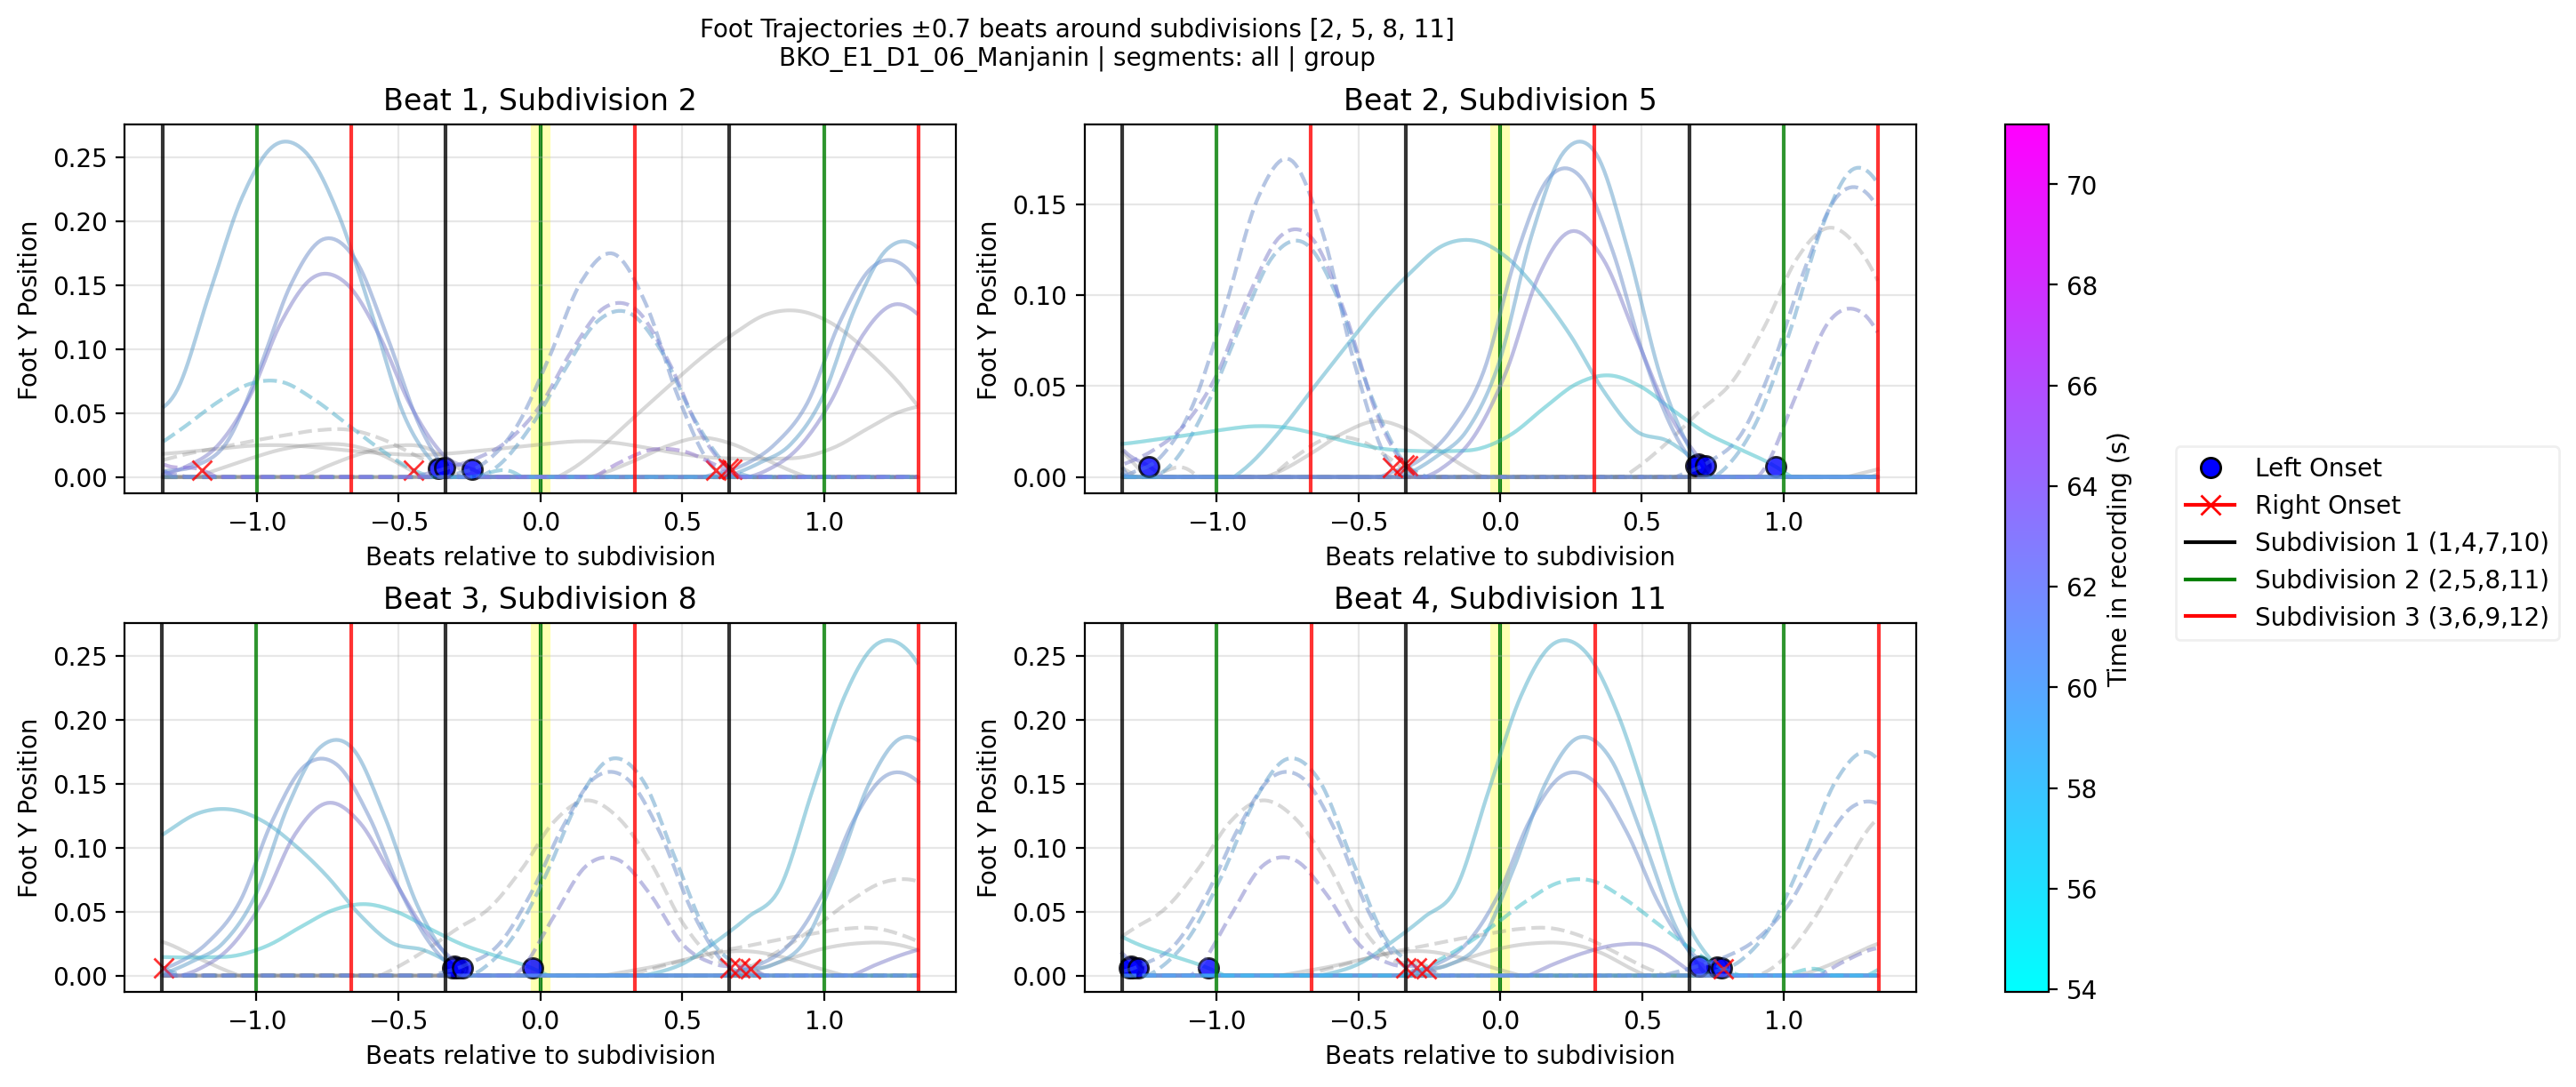

In [6]:
file_name = "BKO_E1_D1_06_Manjanin" #mode_csv.split("_Dancers")[0]
mode_df = pd.read_csv("data/subset_dance_annotation/" + file_name + "_Dancers.csv")

mode_group = mode_df[mode_df["mocap"] == "gr"].reset_index(drop=True)
mode_individual = mode_df[mode_df["mocap"] == "in"].reset_index(drop=True)
mode_audience = mode_df[mode_df["mocap"] == "au"].reset_index(drop=True)

# helper to extract all (start, end) tuples for a mode
def get_segments(df, name):
    if df.empty:
        # print(f"⚠️  No rows for mode '{name}', skipping.")
        return None
    return [(row["Start (in sec)"], row["End (in sec)"]) for _, row in df.iterrows()]

# build a dict of segments
segments = {
    "group":      get_segments(mode_group,      "gr"),
    "individual": get_segments(mode_individual, "in"),
    "audience":   get_segments(mode_audience,   "au")
}

def get_tsegment_for(mode_name, mode_value, suffix):
    """
    Run get_segments on one mode, and return a one-entry dict
    iff it isn’t None.
    """
    seg = get_segments(mode_value, suffix)
    return mode_name, seg if seg is not None else {}


mode_name, segmnt = get_tsegment_for("group", mode_group,      "gr")
    # mode_name, seg = get_tsegment_for("individual", mode_individual, "in")
    # mode_name, seg   = get_tsegment_for("audience",   mode_audience,   "au")
    
    # filter out the empty ones
    # tsegment = {mode: seg for mode, seg in segments.items() if seg is not None}

fig, ax = plot_foot_trajectories_by_subdiv(
    file_name=file_name,
    mode=mode_name,
    base_path_cycles="data/virtual_cycles",
    base_path_logs="data/logs_v1_may",
    time_segments=segmnt,  # Pass all segments for this mode
    n_beats_per_cycle=4, 
    n_subdiv_per_beat=3, 
    nn=4,
    use_cycles=True,
    show_gray_plots=True,
    subdiv_set=[2,5,8,11],      # [2,5,8,11]        [1,4,7,10]
    show_trajectories=True,  # New parameter to control trajectory lines
    show_vlines=False        # New parameter to control vertical lines
)

plt.show(fig)

# fig.savefig(os.path.join(save_dir, f"{file_name}_{mode}.png"))
# plt.close(fig)

### Batch process

In [ ]:
mode_csv_list = os.listdir("data/subset_dance_annotation")

for mode_csv in mode_csv_list:
    file_name = mode_csv.split("_Dancers")[0]
    mode_df = pd.read_csv("data/subset_dance_annotation/" + mode_csv)

    mode_group = mode_df[mode_df["mocap"] == "gr"].reset_index(drop=True)
    mode_individual = mode_df[mode_df["mocap"] == "in"].reset_index(drop=True)
    mode_audience = mode_df[mode_df["mocap"] == "au"].reset_index(drop=True)

    # helper to extract all (start, end) tuples for a mode
    def get_segments(df, name):
        if df.empty:
            print(f"⚠️  No rows for mode '{name}', skipping.")
            return None
        return [(row["Start (in sec)"], row["End (in sec)"]) for _, row in df.iterrows()]

    # build a dict of segments
    segments = {
        "group":      get_segments(mode_group,      "gr"),
        "individual": get_segments(mode_individual, "in"),
        "audience":   get_segments(mode_audience,   "au")
    }

    # filter out the empty ones
    tsegment = {mode: seg for mode, seg in segments.items() if seg is not None}

    save_dir = f"output_static_plot/foot_trajectories_subdiv/{file_name}"
    os.makedirs(save_dir, exist_ok=True)
    for mode, segments in tsegment.items():
        fig, ax = plot_foot_trajectories_by_subdiv(
            file_name=file_name,
            mode=mode,
            base_path_cycles="data/virtual_cycles",
            base_path_logs="data/logs_v1_may",
            time_segments=segments,  # Pass all segments for this mode
            n_beats_per_cycle=4, 
            n_subdiv_per_beat=3, 
            nn=3,
            use_cycles=True,
            show_gray_plots=True,
            subdiv_set=[2,5,8,11],
            show_trajectories=True,  # New parameter to control trajectory lines
            show_vlines=False        # New parameter to control vertical lines
        )
        # Create a filename that includes all segments
        # segment_str = "_".join([f"{start:.1f}_{end:.1f}" for start, end in segments])
        # fig.legend()
        fig.savefig(os.path.join(save_dir, f"{file_name}_{mode}.png"), bbox_inches="tight")
        plt.close(fig)

## plot_foot_trajectories_by_beat

In [10]:
def plot_foot_trajectories_by_beat(
    file_name: str,
    mode: str,
    base_path_cycles: str = "data/virtual_cycles",
    base_path_logs: str = "data/logs_v1_may",
    frame_rate: float = 240,
    time_segments: list = None,  # List of (start, end) tuples
    n_beats_per_cycle: int = 4,
    n_subdiv_per_beat: int = 12,
    nn: int = 8,
    figsize: tuple = (12, 6),
    dpi: int = 200,
    use_cycles: bool = True,
    show_gray_plots: bool = True,
    show_trajectories: bool = True,  # New parameter to control trajectory lines
    show_vlines: bool = True        # New parameter to control vertical lines
):
    """
    Plot left- and right-foot Y-position trajectories ±window around each beat (1,2,3,4),
    marking foot-onset times for cycles that have an onset in the window.
    Optionally plots trajectories for cycles without onsets in gray.

    Parameters
    ----------
    [previous parameters remain the same]
    time_segments : list of tuples
        List of (start, end) time segments to plot. If None, uses default window.
    show_trajectories : bool
        Whether to show the continuous trajectory lines
    show_vlines : bool
        Whether to show vertical lines at onset times
    """
    # Use default window if no segments provided
    if time_segments is None:
        time_segments = [(0, 10)]

    # build file paths
    cycles_csv = os.path.join(base_path_cycles, f"{file_name}_C.csv")
    logs_onset_dir = os.path.join(base_path_logs, f"{file_name}_T", "onset_info")
    left_onsets_csv  = os.path.join(logs_onset_dir, f"{file_name}_T_left_foot_onsets.csv")
    right_onsets_csv = os.path.join(logs_onset_dir, f"{file_name}_T_right_foot_onsets.csv")
    left_zpos_csv    = os.path.join(logs_onset_dir, f"{file_name}_T_left_foot_zpos.csv")
    right_zpos_csv   = os.path.join(logs_onset_dir, f"{file_name}_T_right_foot_zpos.csv")

    # load data
    Lz = pd.read_csv(left_zpos_csv)["zpos"].values
    Rz = pd.read_csv(right_zpos_csv)["zpos"].values
    n_frames = len(Lz)
    times = np.arange(n_frames) / frame_rate

    # interpolation functions
    L_interp = interp1d(times, Lz, bounds_error=False, fill_value="extrapolate")
    R_interp = interp1d(times, Rz, bounds_error=False, fill_value="extrapolate")

    # Get overall time range for color mapping
    total_start = min(seg[0] for seg in time_segments)
    total_end = max(seg[1] for seg in time_segments)
    t_range = total_end - total_start

    # Calculate average cycle duration from all segments
    all_onsets = []
    for seg_start, seg_end in time_segments:
        cyc_df = pd.read_csv(cycles_csv)
        cyc_df = cyc_df[(cyc_df["Virtual Onset"] >= seg_start) & (cyc_df["Virtual Onset"] <= seg_end)]
        if not cyc_df.empty:
            all_onsets.extend(cyc_df["Virtual Onset"].values[:-1])
    
    if not all_onsets:
        raise ValueError("No cycles found in any of the time segments")
    
    # Calculate average cycle duration
    durations = np.diff(sorted(all_onsets))
    avg_cycle = durations.mean()

    # Calculate beat and subdivision lengths
    beat_len = avg_cycle / n_beats_per_cycle
    subdiv_len = beat_len / n_subdiv_per_beat
    half_win = subdiv_len * nn

    # Create figure with subplots for each beat
    fig, axes = plt.subplots(2, 2, figsize=figsize, dpi=dpi)
    axes = axes.flatten()
    cmap = plt.get_cmap('cool')

    # For each beat position (1,2,3,4)
    for beat_idx, ax in enumerate(axes):
        beat_offset = beat_idx * beat_len  # Time offset for this beat
        
        # Process each time segment
        for seg_start, seg_end in time_segments:
            # trim to window
            win_mask = (times >= seg_start) & (times <= seg_end)
            t_win = times[win_mask]
            L_win = Lz[win_mask]
            R_win = Rz[win_mask]

            # cycles (downbeats)
            cyc_df = pd.read_csv(cycles_csv)
            cyc_df = cyc_df[(cyc_df["Virtual Onset"] >= seg_start) & (cyc_df["Virtual Onset"] <= seg_end)]
            onsets = cyc_df["Virtual Onset"].values[:-1]

            # foot onsets
            left_df  = pd.read_csv(left_onsets_csv)
            right_df = pd.read_csv(right_onsets_csv)
            left_times  = left_df[ (left_df["time_sec"]>=seg_start)&(left_df["time_sec"]<=seg_end) ]["time_sec"].values
            right_times = right_df[(right_df["time_sec"]>=seg_start)&(right_df["time_sec"]<=seg_end)]["time_sec"].values

            # Plot gray trajectories if enabled
            if show_gray_plots and show_trajectories:
                for c in onsets:
                    beat_time = c + beat_offset  # Time of this beat in this cycle
                    m = (t_win>=beat_time-half_win)&(t_win<=beat_time+half_win)
                    tr = t_win[m] - beat_time
                    if use_cycles:
                        tr = tr / avg_cycle
                    ax.plot(tr, L_win[m], '-', color='gray', alpha=0.1)
                    ax.plot(tr, R_win[m], '--', color='gray', alpha=0.1)

            # Collect cycles that have foot onsets near this beat
            cyc_L, L_near = [], {}
            cyc_R, R_near = [], {}
            
            for c in onsets:
                beat_time = c + beat_offset
                # Left foot
                hits = left_times[(left_times>=beat_time-half_win)&(left_times<=beat_time+half_win)]
                if len(hits):
                    cyc_L.append(c)
                    L_near[c] = hits
                # Right foot
                hits = right_times[(right_times>=beat_time-half_win)&(right_times<=beat_time+half_win)]
                if len(hits):
                    cyc_R.append(c)
                    R_near[c] = hits

            # Plot left foot trajectories with onsets
            for i, c in enumerate(cyc_L):
                col = cmap((c-total_start)/t_range)
                beat_time = c + beat_offset
                m = (t_win>=beat_time-half_win)&(t_win<=beat_time+half_win)
                tr = t_win[m] - beat_time
                if use_cycles:
                    tr = tr / avg_cycle
                if show_trajectories:
                    ax.plot(tr, L_win[m], '-', color=col, alpha=0.3,
                            label="Left Foot" if i==0 else "")
                for lt in L_near[c]:
                    rel = lt - beat_time  # or beat_time for by_beat version
                    if use_cycles:
                        rel = rel / avg_cycle
                    if show_vlines:
                        ax.axvline(rel, color=col, linestyle='-', alpha=0.5)
                    # Change this line to use a fixed color for left foot markers
                    ax.plot(rel, L_interp(lt), 'o', ms=8, markeredgecolor='k', 
                            markerfacecolor='blue', alpha=0.8)  # Fixed blue color for left foot

            # Plot right foot trajectories with onsets
            for i, c in enumerate(cyc_R):
                col = cmap((c-total_start)/t_range)
                beat_time = c + beat_offset
                m = (t_win>=beat_time-half_win)&(t_win<=beat_time+half_win)
                tr = t_win[m] - beat_time
                if use_cycles:
                    tr = tr / avg_cycle
                if show_trajectories:
                    ax.plot(tr, R_win[m], '--', color=col, alpha=0.3,
                            label="Right Foot" if i==0 else "")
                for rt in R_near[c]:
                    rel = rt - beat_time  # or beat_time for by_beat version
                    if use_cycles:
                        rel = rel / avg_cycle
                    if show_vlines:
                        ax.axvline(rel, color=col, linestyle='--', alpha=0.5)
                    # Change this line to use a fixed color for right foot markers
                    ax.plot(rel, R_interp(rt), 'x', ms=8, markeredgecolor='red', 
                            color='red', alpha=0.8)  # Fixed red color for right foot

        # Decorations for each subplot
        ax.axvline(0, color='k', linewidth=1.5, label="Beat (t=0)")
        for j in range(-nn, nn+1):
            if j!=0:
                pos = j*subdiv_len
                if use_cycles:
                    pos = pos / avg_cycle
                ax.axvline(pos, color='gray', linestyle=':', alpha=0.5)

        xlabel = "Cycles relative to beat" if use_cycles else "Time relative to beat (s)"
        ax.set_xlabel(xlabel)
        ax.set_ylabel("Foot Y Position")
        ax.set_title(f"Beat {beat_idx + 1}")
        ax.grid(True, alpha=0.3)

        # Add legend only to first subplot
        if beat_idx == 0:
            custom = [
                # Line2D([0],[0],color='blue',linestyle='-', lw=2),
                Line2D([0],[0],marker='o', color='w', markerfacecolor='blue', ms=8, markeredgecolor='k'),
                # Line2D([0],[0],color='red',linestyle='--', lw=2),
                Line2D([0],[0],marker='x', color='red', ms=8),
                Line2D([0],[0],color='k', lw=2)
            ]
            # labels = ["Left Trajectory","Left Onset","Right Trajectory",
            #         "Right Onset","Beat (t=0)"] 
            labels = ["Left Onset", "Right Onset","Beat (t=0)"] 
             
            ax.legend(custom, labels, loc='upper left', framealpha=0.3)

    # Add colorbar to the figure
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(total_start, total_end))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axes.ravel().tolist())
    cbar.set_label('Time in recording (s)')

    # Create segment labels for title
    segment_labels = [f"{start:.1f}-{end:.1f}s" for start, end in time_segments]
    segment_str = " | ".join(segment_labels)

    plt.suptitle(
        f"Foot Trajectories ±{2*nn/n_subdiv_per_beat/ n_beats_per_cycle:.1f} beats around each beat\n"
        f"{file_name} | segments: all | {mode}",
        fontsize=10
    )
    
    plt.subplots_adjust(top=0.85)
    fig.set_constrained_layout(True)

    return fig, axes

### may 23

In [12]:
def plot_foot_trajectories_by_beat(
    file_name: str,
    mode: str,
    base_path_cycles: str = "data/virtual_cycles",
    base_path_logs: str = "data/logs_v1_may",
    frame_rate: float = 240,
    time_segments: list = None,  # List of (start, end) tuples
    n_beats_per_cycle: int = 4,
    n_subdiv_per_beat: int = 12,
    nn: int = 8,
    figsize: tuple = (12, 6),
    dpi: int = 200,
    use_cycles: bool = True,
    show_gray_plots: bool = True,
    show_trajectories: bool = True,  # New parameter to control trajectory lines
    show_vlines: bool = True        # New parameter to control vertical lines
):
    """
    Plot left- and right-foot Y-position trajectories ±window around each beat (1,2,3,4),
    marking foot-onset times for cycles that have an onset in the window.
    Optionally plots trajectories for cycles without onsets in gray.

    Parameters
    ----------
    [previous parameters remain the same]
    time_segments : list of tuples
        List of (start, end) time segments to plot. If None, uses default window.
    show_trajectories : bool
        Whether to show the continuous trajectory lines
    show_vlines : bool
        Whether to show vertical lines at onset times
    """
    # Use default window if no segments provided
    if time_segments is None:
        time_segments = [(0, 10)]

    # build file paths
    cycles_csv = os.path.join(base_path_cycles, f"{file_name}_C.csv")
    logs_onset_dir = os.path.join(base_path_logs, f"{file_name}_T", "onset_info")
    left_onsets_csv  = os.path.join(logs_onset_dir, f"{file_name}_T_left_foot_onsets.csv")
    right_onsets_csv = os.path.join(logs_onset_dir, f"{file_name}_T_right_foot_onsets.csv")
    left_zpos_csv    = os.path.join(logs_onset_dir, f"{file_name}_T_left_foot_zpos.csv")
    right_zpos_csv   = os.path.join(logs_onset_dir, f"{file_name}_T_right_foot_zpos.csv")

    # load data
    Lz = pd.read_csv(left_zpos_csv)["zpos"].values
    Rz = pd.read_csv(right_zpos_csv)["zpos"].values
    n_frames = len(Lz)
    times = np.arange(n_frames) / frame_rate

    # interpolation functions
    L_interp = interp1d(times, Lz, bounds_error=False, fill_value="extrapolate")
    R_interp = interp1d(times, Rz, bounds_error=False, fill_value="extrapolate")

    # Get overall time range for color mapping
    total_start = min(seg[0] for seg in time_segments)
    total_end = max(seg[1] for seg in time_segments)
    t_range = total_end - total_start

    # Calculate average cycle duration from all segments
    all_onsets = []
    for seg_start, seg_end in time_segments:
        cyc_df = pd.read_csv(cycles_csv)
        cyc_df = cyc_df[(cyc_df["Virtual Onset"] >= seg_start) & (cyc_df["Virtual Onset"] <= seg_end)]
        if not cyc_df.empty:
            all_onsets.extend(cyc_df["Virtual Onset"].values[:-1])
    
    if not all_onsets:
        raise ValueError("No cycles found in any of the time segments")
    
    # Calculate average cycle duration
    durations = np.diff(sorted(all_onsets))
    avg_cycle = durations.mean()

    # Calculate beat and subdivision lengths
    beat_len = avg_cycle / n_beats_per_cycle
    subdiv_len = beat_len / n_subdiv_per_beat
    half_win = subdiv_len * nn

    # Create figure with subplots for each beat
    fig, axes = plt.subplots(2, 2, figsize=figsize, dpi=dpi)
    axes = axes.flatten()
    cmap = plt.get_cmap('cool')

    # Define subdivision color mapping
    def get_subdiv_color(subdiv):
        # First, normalize the subdivision to be 1-based and within the valid range
        total_subdiv = n_beats_per_cycle * n_subdiv_per_beat
        subdiv = ((subdiv - 1) % total_subdiv) + 1
        
        # For n_subdiv_per_beat = 3, we want:
        # Group 1 (black): 1,4,7,10
        # Group 2 (blue): 2,5,8,11
        # Group 3 (red): 3,6,9,12
        group = ((subdiv - 1) % 3) + 1  # This gives us 1,2,3 for the three groups
        
        if group == 1:
            return 'black'
        elif group == 2:
            return 'green'
        elif group == 3:
            return 'red'
        return 'gray'  # fallback color

    # For each beat position (1,2,3,4)
    for beat_idx, ax in enumerate(axes):
        beat_offset = beat_idx * beat_len  # Time offset for this beat
        
        # Process each time segment
        for seg_start, seg_end in time_segments:
            # trim to window
            win_mask = (times >= seg_start) & (times <= seg_end)
            t_win = times[win_mask]
            L_win = Lz[win_mask]
            R_win = Rz[win_mask]

            # cycles (downbeats)
            cyc_df = pd.read_csv(cycles_csv)
            cyc_df = cyc_df[(cyc_df["Virtual Onset"] >= seg_start) & (cyc_df["Virtual Onset"] <= seg_end)]
            onsets = cyc_df["Virtual Onset"].values[:-1]

            # foot onsets
            left_df  = pd.read_csv(left_onsets_csv)
            right_df = pd.read_csv(right_onsets_csv)
            left_times  = left_df[ (left_df["time_sec"]>=seg_start)&(left_df["time_sec"]<=seg_end) ]["time_sec"].values
            right_times = right_df[(right_df["time_sec"]>=seg_start)&(right_df["time_sec"]<=seg_end)]["time_sec"].values

            # Plot gray trajectories if enabled
            if show_gray_plots and show_trajectories:
                for c in onsets:
                    beat_time = c + beat_offset  # Time of this beat in this cycle
                    m = (t_win>=beat_time-half_win)&(t_win<=beat_time+half_win)
                    tr = t_win[m] - beat_time
                    if use_cycles:
                        tr = tr / beat_len  # Changed from avg_cycle to beat_len
                    ax.plot(tr, L_win[m], '-', color='gray', alpha=0.3)
                    ax.plot(tr, R_win[m], '--', color='gray', alpha=0.3)

            # Collect cycles that have foot onsets near this beat
            cyc_L, L_near = [], {}
            cyc_R, R_near = [], {}
            
            for c in onsets:
                beat_time = c + beat_offset
                # Left foot
                hits = left_times[(left_times>=beat_time-half_win)&(left_times<=beat_time+half_win)]
                if len(hits):
                    cyc_L.append(c)
                    L_near[c] = hits
                # Right foot
                hits = right_times[(right_times>=beat_time-half_win)&(right_times<=beat_time+half_win)]
                if len(hits):
                    cyc_R.append(c)
                    R_near[c] = hits

            # Plot left foot trajectories with onsets
            for i, c in enumerate(cyc_L):
                col = cmap((c-total_start)/t_range)
                beat_time = c + beat_offset
                m = (t_win>=beat_time-half_win)&(t_win<=beat_time+half_win)
                tr = t_win[m] - beat_time
                if use_cycles:
                    tr = tr / beat_len  # Changed from avg_cycle to beat_len
                if show_trajectories:
                    ax.plot(tr, L_win[m], '-', color=col, alpha=0.3,
                            label="Left Foot" if i==0 else "")
                for lt in L_near[c]:
                    rel = lt - beat_time
                    if use_cycles:
                        rel = rel / beat_len  # Changed from avg_cycle to beat_len
                    if show_vlines:
                        ax.axvline(rel, color=col, linestyle='-', alpha=0.5)
                    ax.plot(rel, L_interp(lt), 'o', ms=8, markeredgecolor='k', 
                            markerfacecolor='blue', alpha=0.8)

            # Plot right foot trajectories with onsets
            for i, c in enumerate(cyc_R):
                col = cmap((c-total_start)/t_range)
                beat_time = c + beat_offset
                m = (t_win>=beat_time-half_win)&(t_win<=beat_time+half_win)
                tr = t_win[m] - beat_time
                if use_cycles:
                    tr = tr / beat_len  # Changed from avg_cycle to beat_len
                if show_trajectories:
                    ax.plot(tr, R_win[m], '--', color=col, alpha=0.3,
                            label="Right Foot" if i==0 else "")
                for rt in R_near[c]:
                    rel = rt - beat_time
                    if use_cycles:
                        rel = rel / beat_len  # Changed from avg_cycle to beat_len
                    if show_vlines:
                        ax.axvline(rel, color=col, linestyle='--', alpha=0.5)
                    ax.plot(rel, R_interp(rt), 'x', ms=8, markeredgecolor='red', 
                            color='red', alpha=0.8)

        # Add yellow glow effect at t=0
        ax.axvline(0, color='yellow', linewidth=6, alpha=0.3, zorder=0)  # Glow effect
        ax.axvline(0, color='black', linewidth=1.5, label="Beat (t=0)", zorder=1)  # Main line

        # Add grid lines for other subdivisions
        for j in range(-nn, nn+1):
            if j!=0:
                pos = j*subdiv_len
                if use_cycles:
                    pos = pos / beat_len  # Changed from avg_cycle to beat_len
                # Calculate the subdivision number relative to the current beat
                subdiv_num = beat_idx * n_subdiv_per_beat + j + 1
                # Normalize to be within the valid range
                subdiv_num = ((subdiv_num - 1) % (n_beats_per_cycle * n_subdiv_per_beat)) + 1
                grid_color = get_subdiv_color(subdiv_num)
                ax.axvline(pos, color=grid_color, alpha=0.8, linewidth=1.5)

        xlabel = "Beats relative to beat" if use_cycles else "Time relative to beat (s)"
        ax.set_xlabel(xlabel)
        ax.set_ylabel("Foot Y Position")
        ax.set_title(f"Beat {beat_idx + 1}")
        ax.grid(True, alpha=0.3)

        # Add legend only to first subplot
        # if beat_idx == 0:
        #     custom = [
        #         Line2D([0],[0],marker='o', color='w', markerfacecolor='blue', ms=8, markeredgecolor='k'),
        #         Line2D([0],[0],marker='x', color='red', ms=8),
        #         Line2D([0],[0],color='k', lw=2)
        #     ]
        #     labels = ["Left Onset", "Right Onset","Beat (t=0)"] 
        #     ax.legend(custom, labels, loc='upper left', framealpha=0.3)

    # Add colorbar to the figure
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(total_start, total_end))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axes.ravel().tolist())
    cbar.set_label('Time in recording (s)')

    custom = [
        # Main trajectory and onset markers
        Line2D([0],[0],marker='o', color='w', markerfacecolor='blue', ms=8, markeredgecolor='k'),
        Line2D([0],[0],marker='x', color='red', ms=8),
        # Line2D([0],[0],color='blue', lw=3),
        # Line2D([0],[0],color='red', lw=3, linestyle='--'),
        # Line2D([0],[0],color='purple', lw=3),  # For combined average
        # Subdivision lines
        Line2D([0],[0],color='gray', lw=1.5),
        Line2D([0],[0],color='black', lw=1.5),
        Line2D([0],[0],color='green', lw=1.5),
        Line2D([0],[0],color='red', lw=1.5)
    ]
    labels = [
        "Left Onset", 
        "Right Onset", 
        # "Left Foot Average", 
        # "Right Foot Average", 
        # "Combined Average",
        "Undetected trajectory",
        "Subdivision 1 (1,4,7,10)", 
        "Subdivision 2 (2,5,8,11)", 
        "Subdivision 3 (3,6,9,12)"
    ]
    fig.legend(custom, labels, loc='center right', bbox_to_anchor=(1.20, 0.5), framealpha=0.3)
    
    
    
    # Create segment labels for title
    # segment_labels = [f"{start:.1f}-{end:.1f}s" for start, end in time_segments]
    # segment_str = " | ".join(segment_labels)

    plt.suptitle(
        f"Foot Trajectories ±{2*nn/n_subdiv_per_beat/ n_beats_per_cycle:.1f} beats around each beat\n"
        f"{file_name} | segments: all | {mode}",
        fontsize=10
    )
    
    plt.subplots_adjust(top=0.85)
    fig.set_constrained_layout(True)

    return fig, axes

### single plot

In [ ]:
file_name = "BKO_E1_D1_06_Manjanin" #mode_csv.split("_Dancers")[0]
mode_df = pd.read_csv("data/subset_dance_annotation/" + mode_csv)

mode_group = mode_df[mode_df["mocap"] == "gr"].reset_index(drop=True)
mode_individual = mode_df[mode_df["mocap"] == "in"].reset_index(drop=True)
mode_audience = mode_df[mode_df["mocap"] == "au"].reset_index(drop=True)

# helper to extract all (start, end) tuples for a mode
def get_segments(df, name):
    if df.empty:
        # print(f"⚠️  No rows for mode '{name}', skipping.")
        return None
    return [(row["Start (in sec)"], row["End (in sec)"]) for _, row in df.iterrows()]

# build a dict of segments
segments = {
    "group":      get_segments(mode_group,      "gr"),
    "individual": get_segments(mode_individual, "in"),
    "audience":   get_segments(mode_audience,   "au")
}

def get_tsegment_for(mode_name, mode_value, suffix):
    """
    Run get_segments on one mode, and return a one-entry dict
    iff it isn’t None.
    """
    seg = get_segments(mode_value, suffix)
    return mode_name, seg if seg is not None else {}


mode_name, segmnt = get_tsegment_for("group", mode_group,      "gr")
    # mode_name, seg = get_tsegment_for("individual", mode_individual, "in")
    # mode_name, seg   = get_tsegment_for("audience",   mode_audience,   "au")
    
    # filter out the empty ones
    # tsegment = {mode: seg for mode, seg in segments.items() if seg is not None}

# save_dir = f"output_static_plot/foot_trajectories_subdiv_gray/{file_name}"
# os.makedirs(save_dir, exist_ok=True)

fig, ax = plot_foot_trajectories_by_beat(
            file_name=file_name,
            mode=mode_name,
            base_path_cycles="data/virtual_cycles",
            base_path_logs="data/logs_v1_may",
            time_segments=segmnt,  # Pass all segments for this mode
            n_beats_per_cycle=4, 
            n_subdiv_per_beat=3, 
            nn=3,
            use_cycles=True,
            show_gray_plots=True,
            show_trajectories=True,  # New parameter to control trajectory lines
            show_vlines=False        # New parameter to control vertical lines
        )

plt.show(fig)

# fig.savefig(os.path.join(save_dir, f"{file_name}_{mode}.png"))
# plt.close(fig)

### batch process

In [13]:
mode_csv_list = os.listdir("data/subset_dance_annotation")

for mode_csv in mode_csv_list:
    file_name = mode_csv.split("_Dancers")[0]
    mode_df = pd.read_csv("data/subset_dance_annotation/" + mode_csv)

    mode_group = mode_df[mode_df["mocap"] == "gr"].reset_index(drop=True)
    mode_individual = mode_df[mode_df["mocap"] == "in"].reset_index(drop=True)
    mode_audience = mode_df[mode_df["mocap"] == "au"].reset_index(drop=True)

    # helper to extract all (start, end) tuples for a mode
    def get_segments(df, name):
        if df.empty:
            print(f"⚠️  No rows for mode '{name}', skipping.")
            return None
        return [(row["Start (in sec)"], row["End (in sec)"]) for _, row in df.iterrows()]

    # build a dict of segments
    segments = {
        "group":      get_segments(mode_group,      "gr"),
        "individual": get_segments(mode_individual, "in"),
        "audience":   get_segments(mode_audience,   "au")
    }

    # filter out the empty ones
    tsegment = {mode: seg for mode, seg in segments.items() if seg is not None}

    save_dir = f"output_static_plot/foot_trajectories_beat/{file_name}"
    os.makedirs(save_dir, exist_ok=True)
    for mode, segments in tsegment.items():
        fig, ax = plot_foot_trajectories_by_beat(
            file_name=file_name,
            mode=mode,
            base_path_cycles="data/virtual_cycles",
            base_path_logs="data/logs_v1_may",
            time_segments=segments,  # Pass all segments for this mode
            n_beats_per_cycle=4, 
            n_subdiv_per_beat=3, 
            nn=3,
            use_cycles=True,
            show_gray_plots=True,
            show_trajectories=True,  # New parameter to control trajectory lines
            show_vlines=False        # New parameter to control vertical lines
        )
        # plt.show(fig)
        fig.savefig(os.path.join(save_dir, f"{file_name}_{mode}.png"), bbox_inches="tight")
        plt.close(fig)

⚠️  No rows for mode 'gr', skipping.
⚠️  No rows for mode 'au', skipping.
⚠️  No rows for mode 'gr', skipping.
⚠️  No rows for mode 'au', skipping.
⚠️  No rows for mode 'gr', skipping.
⚠️  No rows for mode 'gr', skipping.
⚠️  No rows for mode 'au', skipping.
⚠️  No rows for mode 'gr', skipping.
⚠️  No rows for mode 'au', skipping.
⚠️  No rows for mode 'gr', skipping.
⚠️  No rows for mode 'au', skipping.
⚠️  No rows for mode 'gr', skipping.
⚠️  No rows for mode 'au', skipping.
⚠️  No rows for mode 'gr', skipping.
⚠️  No rows for mode 'au', skipping.


C:\Users\Sagar\AppData\Local\Temp\ipykernel_18972\1636312557.py:73: RuntimeWarning: Mean of empty slice.
  avg_cycle = durations.mean()
c:\ProgramData\Anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


⚠️  No rows for mode 'gr', skipping.
⚠️  No rows for mode 'au', skipping.
⚠️  No rows for mode 'gr', skipping.
⚠️  No rows for mode 'au', skipping.
⚠️  No rows for mode 'gr', skipping.
⚠️  No rows for mode 'in', skipping.


### Full Cycle trajectory plot

In [14]:
def plot_all_cycles_trajectories(
    file_name: str,
    mode: str,
    base_path_cycles: str = "data/virtual_cycles",
    base_path_logs: str = "data/logs_v1_may",
    frame_rate: float = 240,
    time_segments: list = None,  # List of (start, end) tuples
    n_beats_per_cycle: int = 4,
    n_subdiv_per_beat: int = 12,
    figsize: tuple = (12, 6),
    dpi: int = 200,
    show_trajectories: bool = True,  # Control trajectory lines
    show_vlines: bool = True,        # Control vertical lines
    show_gray_plots: bool = True     # Control gray trajectory plots
):
    """
    Plot all foot trajectories in a single plot with grand average.
    Shows beat and subdivision lines with colors.
    X-axis shows beats 1-4 directly.
    """
    # Use default window if no segments provided
    if time_segments is None:
        time_segments = [(0, 10)]

    # build file paths
    cycles_csv = os.path.join(base_path_cycles, f"{file_name}_C.csv")
    logs_onset_dir = os.path.join(base_path_logs, f"{file_name}_T", "onset_info")
    left_onsets_csv  = os.path.join(logs_onset_dir, f"{file_name}_T_left_foot_onsets.csv")
    right_onsets_csv = os.path.join(logs_onset_dir, f"{file_name}_T_right_foot_onsets.csv")
    left_zpos_csv    = os.path.join(logs_onset_dir, f"{file_name}_T_left_foot_zpos.csv")
    right_zpos_csv   = os.path.join(logs_onset_dir, f"{file_name}_T_right_foot_zpos.csv")

    # load data
    Lz = pd.read_csv(left_zpos_csv)["zpos"].values
    Rz = pd.read_csv(right_zpos_csv)["zpos"].values
    n_frames = len(Lz)
    times = np.arange(n_frames) / frame_rate

    # interpolation functions
    L_interp = interp1d(times, Lz, bounds_error=False, fill_value="extrapolate")
    R_interp = interp1d(times, Rz, bounds_error=False, fill_value="extrapolate")

    # Get overall time range for color mapping
    total_start = min(seg[0] for seg in time_segments)
    total_end = max(seg[1] for seg in time_segments)
    t_range = total_end - total_start

    # Calculate average cycle duration from all segments
    all_onsets = []
    for seg_start, seg_end in time_segments:
        cyc_df = pd.read_csv(cycles_csv)
        cyc_df = cyc_df[(cyc_df["Virtual Onset"] >= seg_start) & (cyc_df["Virtual Onset"] <= seg_end)]
        if not cyc_df.empty:
            all_onsets.extend(cyc_df["Virtual Onset"].values[:-1])
    
    if not all_onsets:
        raise ValueError("No cycles found in any of the time segments")
    
    # Calculate average cycle duration
    durations = np.diff(sorted(all_onsets))
    avg_cycle = durations.mean()

    # Calculate beat and subdivision lengths
    beat_len = avg_cycle / n_beats_per_cycle
    subdiv_len = beat_len / n_subdiv_per_beat

    # Create figure
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    cmap = plt.get_cmap('cool')

    # Define subdivision color mapping
    def get_subdiv_color(subdiv):
        total_subdiv = n_beats_per_cycle * n_subdiv_per_beat
        subdiv = ((subdiv - 1) % total_subdiv) + 1
        group = ((subdiv - 1) % 3) + 1
        if group == 1:
            return 'black'
        elif group == 2:
            return 'green'
        elif group == 3:
            return 'red'
        return 'gray'

    # Process each time segment
    all_L_trajectories = []
    all_R_trajectories = []
    all_times = []

    for seg_start, seg_end in time_segments:
        # trim to window
        win_mask = (times >= seg_start) & (times <= seg_end)
        t_win = times[win_mask]
        L_win = Lz[win_mask]
        R_win = Rz[win_mask]

        # cycles (downbeats)
        cyc_df = pd.read_csv(cycles_csv)
        cyc_df = cyc_df[(cyc_df["Virtual Onset"] >= seg_start) & (cyc_df["Virtual Onset"] <= seg_end)]
        onsets = cyc_df["Virtual Onset"].values[:-1]

        # foot onsets
        left_df  = pd.read_csv(left_onsets_csv)
        right_df = pd.read_csv(right_onsets_csv)
        left_times  = left_df[(left_df["time_sec"]>=seg_start)&(left_df["time_sec"]<=seg_end)]["time_sec"].values
        right_times = right_df[(right_df["time_sec"]>=seg_start)&(right_df["time_sec"]<=seg_end)]["time_sec"].values

        # Plot trajectories for each cycle
        for c in onsets:
            # Convert time to beat position (1-4)
            cycle_start = c
            cycle_end = c + avg_cycle
            m = (t_win >= cycle_start) & (t_win <= cycle_end)
            tr = (t_win[m] - cycle_start) / beat_len  # Convert to beat positions 1-4
            
            if show_trajectories:
                col = cmap((c-total_start)/t_range)
                
                # # Check if this cycle has any onsets
                # has_left_onsets = any(cycle_start <= lt <= cycle_end for lt in left_times)
                # has_right_onsets = any(cycle_start <= rt <= cycle_end for rt in right_times)
                
                # # Plot gray trajectories only for cycles without onsets
                # if show_gray_plots:
                #     if not has_left_onsets:
                #         ax.plot(tr, L_win[m], '-', color='black', alpha=0.3)
                #     if not has_right_onsets:
                #         ax.plot(tr, R_win[m], '--', color='black', alpha=0.3)
                
                # # Plot colored trajectories for cycles with onsets
                # if has_left_onsets:
                #     ax.plot(tr, L_win[m], '-', color=col, alpha=0.3, label="Left Foot" if c==onsets[0] else "")
                # if has_right_onsets:
                #     ax.plot(tr, R_win[m], '--', color=col, alpha=0.3, label="Right Foot" if c==onsets[0] else "")
                
                # Check if this cycle has any onsets at all
                has_any_onsets = any(cycle_start <= t <= cycle_end for t in left_times) or any(cycle_start <= t <= cycle_end for t in right_times)
                
                # Plot gray trajectories only for cycles without any onsets
                if show_gray_plots and not has_any_onsets:
                    ax.plot(tr, L_win[m], '-', color='gray', alpha=0.9)
                    ax.plot(tr, R_win[m], '--', color='gray', alpha=0.9)
                
                # Plot colored trajectories for cycles with any onsets
                if has_any_onsets:
                    ax.plot(tr, L_win[m], '-', color=col, alpha=0.3, label="Left Foot" if c==onsets[0] else "")
                    ax.plot(tr, R_win[m], '--', color=col, alpha=0.3, label="Right Foot" if c==onsets[0] else "")
                            
                # Store ALL trajectories for grand average (removed the condition)
                all_L_trajectories.append(L_win[m])
                all_R_trajectories.append(R_win[m])
                all_times.append(tr)

                # Plot markers for foot onsets
                for lt in left_times:
                    if cycle_start <= lt <= cycle_end:
                        rel = (lt - cycle_start) / beat_len
                        if show_vlines:
                            ax.axvline(rel, color=col, linestyle='-', alpha=0.5)
                        ax.plot(rel, L_interp(lt), 'o', ms=8, markeredgecolor='k', 
                                markerfacecolor='blue', alpha=0.8)

                for rt in right_times:
                    if cycle_start <= rt <= cycle_end:
                        rel = (rt - cycle_start) / beat_len
                        if show_vlines:
                            ax.axvline(rel, color=col, linestyle='--', alpha=0.5)
                        ax.plot(rel, R_interp(rt), 'x', ms=8, markeredgecolor='red', 
                                color='red', alpha=0.8)

    # Calculate and plot grand average
    if all_L_trajectories and all_R_trajectories:
        # Interpolate all trajectories to the same time points
        common_times = np.linspace(0, n_beats_per_cycle, 100)
        
        L_avg = np.zeros(len(common_times))
        R_avg = np.zeros(len(common_times))
        count = 0
        
        for L_traj, R_traj, t_traj in zip(all_L_trajectories, all_R_trajectories, all_times):
            if len(t_traj) > 1:  # Only use trajectories with more than one point
                L_interp = interp1d(t_traj, L_traj, bounds_error=False, fill_value="extrapolate")
                R_interp = interp1d(t_traj, R_traj, bounds_error=False, fill_value="extrapolate")
                L_avg += L_interp(common_times)
                R_avg += R_interp(common_times)
                count += 1
        
        if count > 0:
            L_avg /= count
            R_avg /= count
            ax.plot(common_times, L_avg, '-', color='blue', linewidth=3, label='Left Foot Average')
            ax.plot(common_times, R_avg, '--', color='red', linewidth=3, label='Right Foot Average')

    # # Calculate and plot grand average combined left and right
    # if all_L_trajectories and all_R_trajectories:
    #     # Interpolate all trajectories to the same time points
    #     common_times = np.linspace(0, n_beats_per_cycle, 100)
        
    #     # Single array for combined average
    #     combined_avg = np.zeros(len(common_times))
    #     count = 0
        
    #     for L_traj, R_traj, t_traj in zip(all_L_trajectories, all_R_trajectories, all_times):
    #         if len(t_traj) > 1:  # Only use trajectories with more than one point
    #             L_interp = interp1d(t_traj, L_traj, bounds_error=False, fill_value="extrapolate")
    #             R_interp = interp1d(t_traj, R_traj, bounds_error=False, fill_value="extrapolate")
    #             # Combine left and right trajectories
    #             combined_avg += (L_interp(common_times) + R_interp(common_times)) / 2
    #             count += 1
        
    #     if count > 0:
    #         combined_avg /= count
    #         ax.plot(common_times, combined_avg, '-', color='purple', linewidth=3, label='Combined Foot Average')
        
    
    
    # Add beat and subdivision lines
    for beat in range(1, n_beats_per_cycle + 1):
        ax.axvline(beat, color='black', linewidth=2, alpha=0.8)
        # Add subdivision lines
        for subdiv in range(1, n_subdiv_per_beat):
            subdiv_pos = beat - 1 + subdiv/n_subdiv_per_beat
            subdiv_num = (beat - 1) * n_subdiv_per_beat + subdiv + 1
            grid_color = get_subdiv_color(subdiv_num)
            ax.axvline(subdiv_pos, color=grid_color, alpha=0.8, linewidth=1.5)

    ax.set_xlabel("Beat Position")
    ax.set_ylabel("Foot Y Position")
    ax.set_title(f"All Cycles Trajectories with Grand Average\n{file_name} | {mode}")
    ax.grid(True, alpha=0.3)
    
    # # Add legend
    # custom = [
    #     Line2D([0],[0],marker='o', color='w', markerfacecolor='blue', ms=8, markeredgecolor='k'),
    #     Line2D([0],[0],marker='x', color='red', ms=8),
    #     Line2D([0],[0],color='blue', lw=3),
    #     Line2D([0],[0],color='red', lw=3, linestyle='--')
    # ]
    # labels = ["Left Onset", "Right Onset", "Left Foot Average", "Right Foot Average"]
    # ax.legend(custom, labels, loc='upper left', framealpha=0.3)
    
    # Add all legends together outside the plot
    custom = [
        # Main trajectory and onset markers
        Line2D([0],[0],marker='o', color='w', markerfacecolor='blue', ms=8, markeredgecolor='k'),
        Line2D([0],[0],marker='x', color='red', ms=8),
        Line2D([0],[0],color='blue', lw=3),
        Line2D([0],[0],color='red', lw=3, linestyle='--'),
        # Line2D([0],[0],color='purple', lw=3),  # For combined average
        # Subdivision lines
        Line2D([0],[0],color='gray', lw=1.5),
        Line2D([0],[0],color='black', lw=1.5),
        Line2D([0],[0],color='green', lw=1.5),
        Line2D([0],[0],color='red', lw=1.5)
    ]
    labels = [
        "Left Onset", 
        "Right Onset", 
        "Left Foot Average", 
        "Right Foot Average", 
        # "Combined Average",
        "Undetected trajectory",
        "Subdivision 1 (1,4,7,10)", 
        "Subdivision 2 (2,5,8,11)", 
        "Subdivision 3 (3,6,9,12)"
    ]
    fig.legend(custom, labels, loc='center right', bbox_to_anchor=(1.15, 0.5), framealpha=0.3)
    

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(total_start, total_end))
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label='Time in recording (s)')

    plt.tight_layout()
    return fig, ax

## Single Plot

In [ ]:
# mode_csv_list = os.listdir("data/subset_dance_annotation")

# for mode_csv in mode_csv_list:
file_name = "BKO_E1_D1_06_Manjanin" #mode_csv.split("_Dancers")[0]
mode_df = pd.read_csv("data/subset_dance_annotation/" + mode_csv)

mode_group = mode_df[mode_df["mocap"] == "gr"].reset_index(drop=True)
mode_individual = mode_df[mode_df["mocap"] == "in"].reset_index(drop=True)
mode_audience = mode_df[mode_df["mocap"] == "au"].reset_index(drop=True)

# helper to extract all (start, end) tuples for a mode
def get_segments(df, name):
    if df.empty:
        # print(f"⚠️  No rows for mode '{name}', skipping.")
        return None
    return [(row["Start (in sec)"], row["End (in sec)"]) for _, row in df.iterrows()]

# build a dict of segments
segments = {
    "group":      get_segments(mode_group,      "gr"),
    "individual": get_segments(mode_individual, "in"),
    "audience":   get_segments(mode_audience,   "au")
}

def get_tsegment_for(mode_name, mode_value, suffix):
    """
    Run get_segments on one mode, and return a one-entry dict
    iff it isn’t None.
    """
    seg = get_segments(mode_value, suffix)
    return mode_name, seg if seg is not None else {}


mode_name, segmnt = get_tsegment_for("group", mode_group,      "gr")
    # mode_name, seg = get_tsegment_for("individual", mode_individual, "in")
    # mode_name, seg   = get_tsegment_for("audience",   mode_audience,   "au")
    
    # filter out the empty ones
    # tsegment = {mode: seg for mode, seg in segments.items() if seg is not None}

save_dir = f"output_static_plot/all_cycles_trajectories/{file_name}"
os.makedirs(save_dir, exist_ok=True)

fig, ax = plot_all_cycles_trajectories(
            file_name=file_name,
            mode=mode_name,
            base_path_cycles="data/virtual_cycles",
            base_path_logs="data/logs_v1_may",
            time_segments=segmnt,  # Pass all segments for this mode
            n_beats_per_cycle=4, 
            n_subdiv_per_beat=3, 
            # nn=3,
            show_gray_plots= True,
            show_trajectories= True,  # New parameter to control trajectory lines
            # show_grand_average= True,
            show_vlines= False        # New parameter to control vertical lines
        )

plt.show(fig)

# fig.savefig(os.path.join(save_dir, f"{file_name}_{mode}.png"))
# plt.close(fig)

## Batch process

In [ ]:
mode_csv_list = os.listdir("data/subset_dance_annotation")

for mode_csv in mode_csv_list:
    file_name = mode_csv.split("_Dancers")[0]
    mode_df = pd.read_csv("data/subset_dance_annotation/" + mode_csv)

    mode_group = mode_df[mode_df["mocap"] == "gr"].reset_index(drop=True)
    mode_individual = mode_df[mode_df["mocap"] == "in"].reset_index(drop=True)
    mode_audience = mode_df[mode_df["mocap"] == "au"].reset_index(drop=True)

    # helper to extract all (start, end) tuples for a mode
    def get_segments(df, name):
        if df.empty:
            print(f"⚠️  No rows for mode '{name}', skipping.")
            return None
        return [(row["Start (in sec)"], row["End (in sec)"]) for _, row in df.iterrows()]

    # build a dict of segments
    segments = {
        "group":      get_segments(mode_group,      "gr"),
        "individual": get_segments(mode_individual, "in"),
        "audience":   get_segments(mode_audience,   "au")
    }

    # filter out the empty ones
    tsegment = {mode: seg for mode, seg in segments.items() if seg is not None}

    save_dir = f"output_static_plot/trajectories_all_cycles/{file_name}"
    os.makedirs(save_dir, exist_ok=True)
    for mode, segments in tsegment.items():
        fig, ax = plot_all_cycles_trajectories(
                    file_name=file_name,
                    mode=mode,
                    base_path_cycles="data/virtual_cycles",
                    base_path_logs="data/logs_v1_may",
                    time_segments=segments,  # Pass all segments for this mode
                    n_beats_per_cycle=4, 
                    n_subdiv_per_beat=3, 
                    # nn=3,
                    show_gray_plots= True,
                    show_trajectories= True,  # New parameter to control trajectory lines
                    # show_grand_average= True,
                    show_vlines= False        # New parameter to control vertical lines
                )

        # plt.show(fig)

        fig.savefig(os.path.join(save_dir, f"{file_name}_{mode}.png"), bbox_inches="tight")
        plt.close(fig)

### Move the plots into mode wise folder

In [18]:
import os
import shutil

# Define your source and destination base directories
input_base_dir  = "output_static_plot/foot_trajectories_subdiv"
output_base_dir = "output_static_plot/categorized_subdiv"  # change this to wherever you want the three dirs

# List of categories and their corresponding suffixes
categories = ["audience", "group", "individual"]

# Create the category directories under the output base
for cat in categories:
    os.makedirs(os.path.join(output_base_dir, cat), exist_ok=True)

# Walk through each trajectory folder in the input base
for trajec in os.listdir(input_base_dir):
    trajec_path = os.path.join(input_base_dir, trajec)
    if not os.path.isdir(trajec_path):
        continue

    # Copy files matching each category into its directory
    for fname in os.listdir(trajec_path):
        for cat in categories:
            if fname.endswith(f"_{cat}.png"):
                src = os.path.join(trajec_path, fname)
                dst = os.path.join(output_base_dir, cat, fname)
                shutil.copy2(src, dst)
                break


In [ ]:
import pickle

mode_csv_list = os.listdir("data/subset_dance_annotation")
for mode_csv in mode_csv_list:
    file_name = mode_csv.split("_Dancers")[0]
    mode_df = pd.read_csv("data/subset_dance_annotation/" + mode_csv)

    mode_group = mode_df[mode_df["mocap"] == "gr"].reset_index(drop=True)
    mode_individual = mode_df[mode_df["mocap"] == "in"].reset_index(drop=True)
    mode_audience = mode_df[mode_df["mocap"] == "au"].reset_index(drop=True)

    # helper to extract all (start, end) tuples for a mode
    def get_segments(df, name):
        if df.empty:
            print(f"⚠️  No rows for mode '{name}', skipping.")
            return None
        return [(row["Start (in sec)"], row["End (in sec)"]) for _, row in df.iterrows()]

    # build a dict of segments
    segments = {
        "group":      get_segments(mode_group,      "gr"),
        "individual": get_segments(mode_individual, "in"),
        "audience":   get_segments(mode_audience,   "au")
    }

    # filter out the empty ones
    tsegment = {mode: seg for mode, seg in segments.items() if seg is not None}

    output_name = mode_csv.split(".csv")[0]
    output_path = f"data/subset_dance_annotation_pickles/{output_name}.pkl"
    with open(output_path, "wb") as f:
        pickle.dump(tsegment, f)
 

In [16]:
with open(f"data/subset_dance_annotation_pickles/BKO_E2_D4_02_Maraka_Dancers.pkl", "rb") as f:
    cycle_segments = pickle.load(f)

In [23]:
cycle_segments["audience"]

[(94.9, 106.88),
 (106.88, 121.42),
 (121.42, 133.84),
 (145.84, 158.02),
 (148.24, 158.74),
 (160.7, 171.88),
 (161.7, 179.2)]